## Direct and Broadcast messaging
AutoGen runtime can deliver messages in two different ways: **Direct** or **Broadcast**.

### Direct
In direct mode, the sender must provide the `Agent ID` of the receiver.  

The runtime will check if an instance with that agent id already exists, if not will create it and the will deliver the message.  

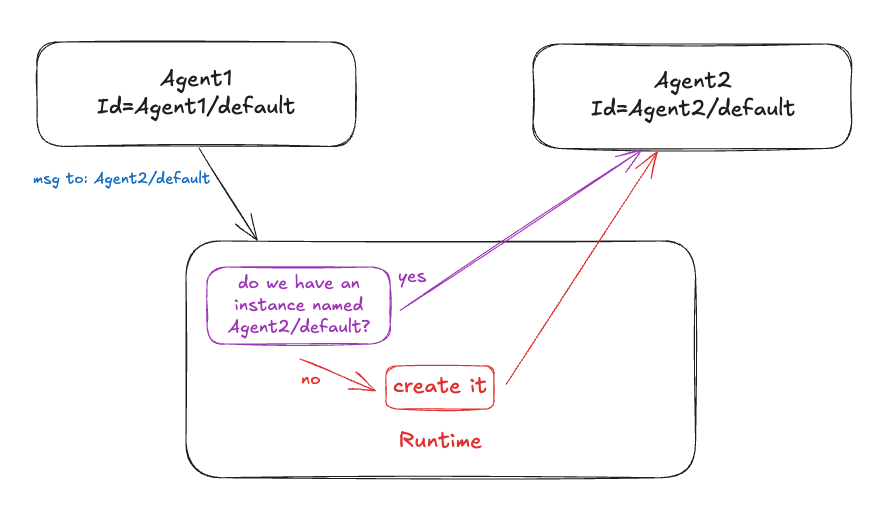

### Broadcast
In this case, there is no direct one-to-one communication, what happen instead is that agents register to some topics
and the sender of the message does not know who will handle it.

Imagine kind of *"I am Agent01 and i am interested in code-generation and code-refactoring topics"* 

In order for the runtime to understand who is interested on a specific message, the message must include a **Topic Identifier**

### Topic Identifier
Similar to `Agent_ID` the `Topic_ID` uniquely identifies a message topic and it's used to identify, and then deliver, the message to
those who subscribed to that specific `Topic_ID`.

A topic is made up of two parts: **Type** and **Source**

- **Topic Type:** Identifies the type of message (e.g. 'generate_code_request','refund_order','create_email')
- **Topic Source:** Is the unique identifier for a topic within a topic type (e.g. for 'create_email' type could be 'consumer' to identify consumers email vs others kinds like 'business')

Think of **Topic_Type** as the family of topics while **Topic_Source** being a sub-category inside the family.  

`Topic_ID` is identified by a string with this format: `Topic_Type/Topic_Source` and when not specified the topic source 
will be set to 'default'.

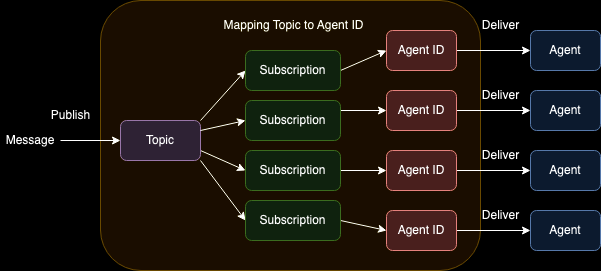


Here's an example of a [Type-based subscription](https://microsoft.github.io/autogen/stable/user-guide/core-user-guide/core-concepts/topic-and-subscription.html#type-based-subscription) 
where a specific topic is mapped to a specific agent:

```python
runtime = SingleThreadedAgentRuntime()
await runtime.add_subscription(
        TypeSubscription(topic_type="create_email", agent_type="email_agent")
    )
```
and here is an example of how a message can be broadcasted:

```python
 await self.publish_message(
            Message("Create a confirmation email for user XYZ"),
            topic_id=TopicId(type="create_email", source="consumer"),
        )
```

Note that when the message will be published, the runtime, if not already existing, will create an instance of an agent with ID = `<Agent_Type>/<TopicSource>`

### Single tenant subscription examples

Let's say you have 2 agents: 'coder_agent' and 'reviewer_agent' and you need to be able to send them a 'reset' message.  

What you can do is, after registering the agents in the runtime, create the following Type Subscriptions, 
since both Agent are subscribed to the 'reset' topic when published it will be delivered to both.

```python
runtime = SingleThreadedAgentRuntime()

# Agent registration
await CoderAgent.register(runtime, "coder_agent", lambda: CoderAgent(...)
await ReviewerAgent.register(runtime, "reviewer_agent", lambda: ReviewerAgent(...)

# Subcriptions
TypeSubscription(topic_type="reset", agent_type="coder_agent")
TypeSubscription(topic_type="reset", agent_type="reviewer_agent")
...
...

# Send the reset message to both agents
await self.publish_message(
            Message("Reset your state"),
            topic_id=TopicId(type="reset", source="default"),
        )
```

In case you want instead each agent to handle a specific topic we can use the following code:

```python
runtime = SingleThreadedAgentRuntime()

# Agent registration
await CoderAgent.register(runtime, "coder_agent", lambda: CoderAgent(...)
await ReviewerAgent.register(runtime, "reviewer_agent", lambda: ReviewerAgent(...)

# Subcriptions
TypeSubscription(topic_type="generate", agent_type="coder_agent")
TypeSubscription(topic_type="inspect", agent_type="reviewer_agent")
...
...

# Send the inspect message to reviewer agent
await self.publish_message(
            Message("Code: {...}"),
            topic_id=TopicId(type="inspect", source="default"),
        )
```

where each single topic maps to a dedicated agent. 

## Multi-tenant subscription examples
In the previous examples the topic source was always set to 'default' meaning that the related agent instance that will receive the message have an `Agent_ID` equal to `agent_type/default`
And since all the messages use "default" as source the same instance will handle, sequentially, all the messages.  

If we want the same message processed by different instances (e.g. I want messages related to user session 1 to be handled by their own independent agent instances) 
what we have to do is to change the topic source.

In this example, the message uses a unique session identifier as topic source, meaning that each one will have its own separated instance

```python
runtime = SingleThreadedAgentRuntime()

# Agent registration
await CoderAgent.register(runtime, "coder_agent", lambda: CoderAgent(...)
await ReviewerAgent.register(runtime, "reviewer_agent", lambda: ReviewerAgent(...)

# Subcriptions
TypeSubscription(topic_type="generate", agent_type="coder_agent")
TypeSubscription(topic_type="inspect", agent_type="reviewer_agent")
...
...

# Send the inspect message to a dedicated instance of the reviewer agent
session_id=get_session_id()
await self.publish_message(
            Message("Code: {...}"),
            topic_id=TopicId(type="inspect", source=session_id),
        )
```

We had an overview of how to register an agent, how to subscribe and send/publish messages, but how do we handle messages?
Let's see it in the next notebook.